Challenge 3
- Use the data file "challenge 3.gwf" with channel "H1:CHALLENGE3"
- These are real LIGO data from O2, though we've adjusted the time labels and added some simulated signals.
- The data contain a loud simulated signal with m1 = m2 = 10 solar masses.
1. What is the merger time of this signal?
2. What is the matched-filter SNR of this signal?


In [ ]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu
! pip install matplotlib==3.1.3

     |████████████████████████████████| 46.2 MB 1.7 MB/s 
     |████████████████████████████████| 1.4 MB 36.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 5.2 MB/s 
     |████████████████████████████████| 295 kB 44.5 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 3.6 MB 28.2 MB/s 
     |████████████████████████████████| 1.4 MB 24.5 MB/s 
     |████████████████████████████████| 11.2 MB 35.3 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 6.7 MB 18.9 MB/s 
     |██████████████

In [ ]:
# Downloading the data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge3.gwf', channel="H1:CHALLENGE3")

# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')


--2022-02-14 22:43:34--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf’

challenge3.gwf      100%[===================>] 244.92M  20.2MB/s    in 32s     

2022-02-14 22:44:07 (7.70 MB/s) - ‘challenge3.gwf’ saved [256815066/256815066]



In [ ]:
samplerate = gwpy_strain.sample_rate
duration = gwpy_strain.duration
print(gwpy_strain)
print('This is the sampling rate of the data:', samplerate, 'and the duration is: ', duration)

TimeSeries([-3.04517369e-19, -3.35465069e-19, -3.35210566e-19,
            ...,  4.46471052e-19,  5.07624678e-19,
             4.98623016e-19]
           unit: ct,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE3,
           channel: H1:CHALLENGE3)
This is the sampling rate of the data: 4096.0 Hz and the duration is:  4096.0 s


The following plot shows the data is the time domain. 

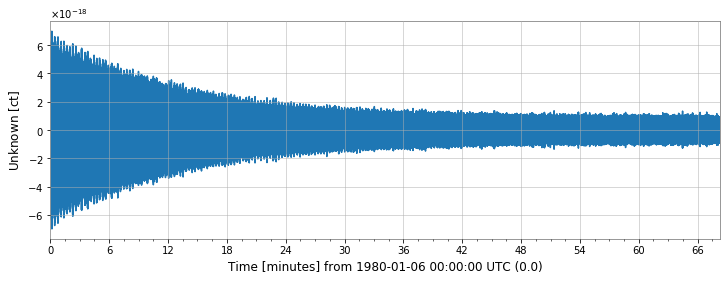

In [ ]:
%matplotlib inline

plot = gwpy_strain.plot()

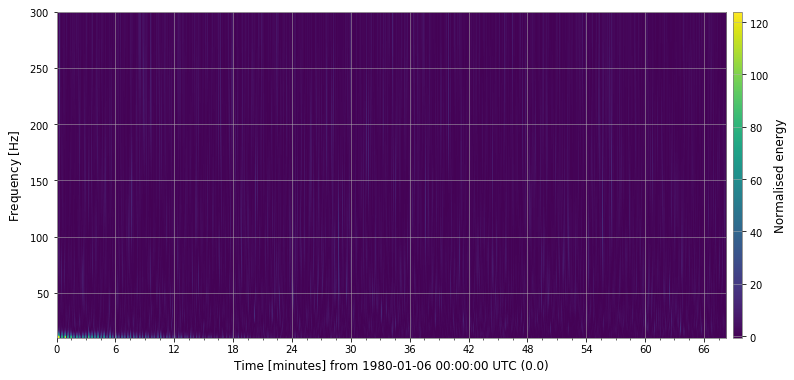

In [ ]:
hq = gwpy_strain.q_transform(frange=(10, 300))
plot = hq.plot()
plot.colorbar(label="Normalised energy")


In [ ]:
epoch = gwpy_strain.epoch
print(epoch)

0.0


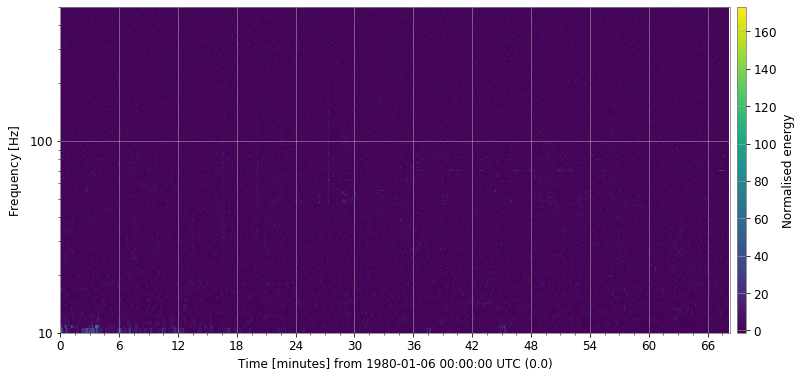

In [ ]:
hq = gwpy_strain.q_transform(frange=(10, 500), qrange=(250, 550)) 
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Similar to challenge 2, a q transform is plotted and the qrange is changed. However, it is not possible to seed a clear signal and only faint signals can be seen in the plot. Probably the qrange and colour range have to be adjusted further to see a signal. 

Again a template for the signal is calculated similar to challenge 2 however the masses are changed to 10 solar masses.

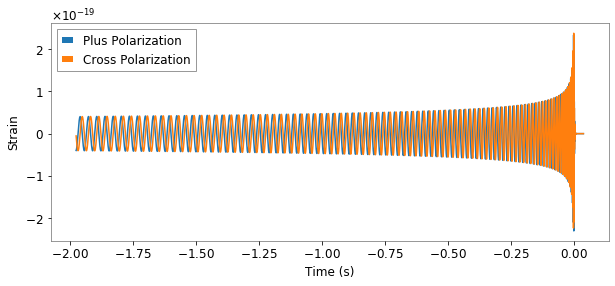

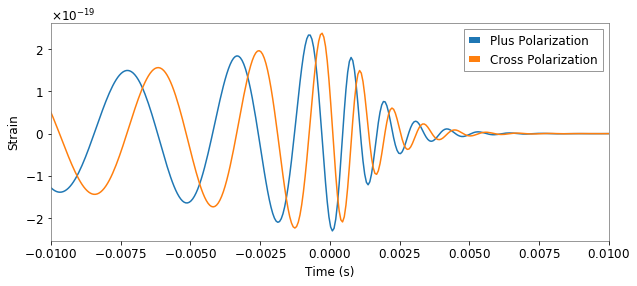

In [ ]:
%matplotlib inline
from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/16384,
                         f_lower=30,
                         spin1z=0,
                         spin2z=0)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

In [ ]:
samplerate = pycbc_strain.sample_rate
nfrequency = samplerate/2
samplelength = 4
print('The sampling rate is', samplerate, 'and the Nyquist frequency is', nfrequency, '.')

The sampling rate is 4096.0 and the Nyquist frequency is 2048.0 .


In [ ]:
from pycbc import frame
from pycbc.filter import matched_filter
import numpy
import pylab
from pycbc.filter import resample_to_delta_t, highpass

The PSD is calculated and plotted on a log log scale. Then the steps from challenge 2 are repeated to find the SNR for the data. The data is downsampled and conditioned and then the PSD is calculated for the contioned data.

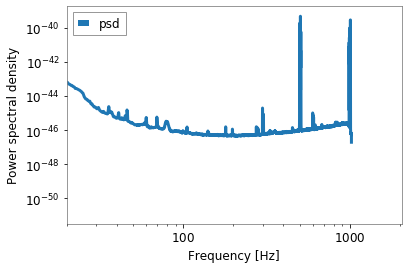

In [ ]:
psd = pycbc_strain.psd(samplelength)
# plot it:

pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='psd')
pylab.xlim(xmin=20, xmax=2048)
pylab.xlabel('Frequency [Hz]')
pylab.ylabel('Power spectral density')
pylab.legend()
pylab.grid()
pylab.show()

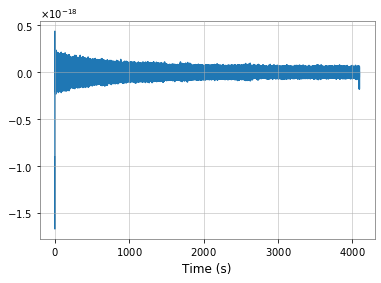

In [ ]:
# Remove the low frequency content and downsample the data to 2048Hz
pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

pylab.plot(pycbc_strain.sample_times, pycbc_strain)
pylab.xlabel('Time (s)')
pylab.show()

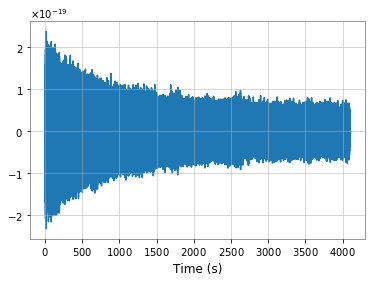

In [ ]:
conditioned = pycbc_strain.crop(3,3) # cropping first three and last three seconds of the data

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [ ]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series since the data length is 128 which is divisible by 4
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [ ]:
from pycbc.waveform import get_td_waveform

m = 10 # Solar masses
s = 0 # the spin is 0
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20,
                     spin1z=s,
                     spin2z=s)

# Resize the vector to match our data
hp.resize(len(conditioned))

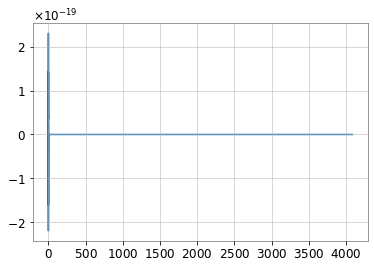

In [ ]:
pylab.plot(hp.sample_times, hp)

Text(0, 0.5, 'Strain')

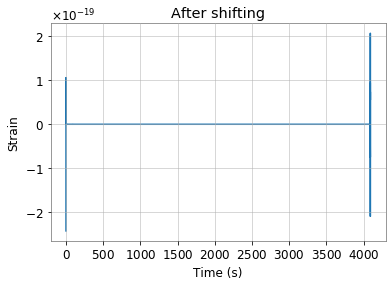

In [ ]:
# Let's plot the signal after shifting
template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

Finally the SNR is plotted against time. The highest SNR is 28 however there are two more signals that have a SNR of higher than 8 so it is possible that there is not just one signal present. 

We found a signal at 2483.9672851565006s with SNR 28.902967927418107


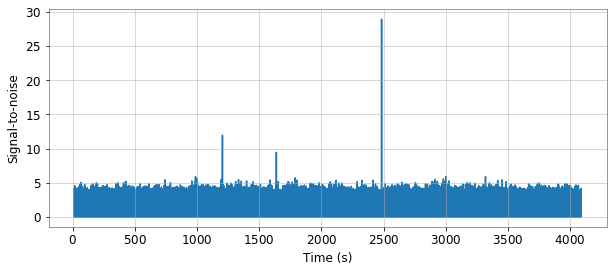

In [ ]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))